In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf
import pandas as pd

In [ ]:
def load_data(symbol):
    ticker = yf.Ticker(symbol)
    data = ticker.history(period="1y")
    data.drop(columns=['Dividends', 'Stock Splits', 'Open', 'High', 'Low', 'Volume'], inplace=True)
    data.rename(columns={'Close': 'actual'}, inplace=True)
    return data

symbols = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'TSLA', 'NVDA', 'INTC', 'CSCO', 'ADBE', 'PYPL', 'NFLX', 'CMCSA', 'PEP', 'COST', 'TMUS', 'AVGO', 'QCOM', 'TXN', 'INTU', 'AMD', 'MU', 'AMAT', 'LRCX']    
dfs = list()
for symbol in symbols:
    df = load_data(symbol)
    df['symbol'] = symbol
    dfs.append(df)

df = pd.concat(dfs)
df.to_csv('historical_data.csv')

In [ ]:
def load_data():
    data = pd.read_csv('historical_data.csv', index_col='Date')
    data.index = pd.to_datetime(data.index, utc=True, format='ISO8601')
    data.index = data.index.date

    symbol = data.symbol.unique().tolist()[0]
    df = data[data.symbol == symbol].copy()
    df.index = pd.to_datetime(df.index)
    df.shape

    df['buy'] = 0
    df['sell'] = 0
    df['shares'] = 0
    df['buy_in'] = 0.0
    df['current_value'] = 0.0
    df['investment'] = 0.0
    df['profit'] = 0.0
    df['total_profit'] = 0.0
    df['action'] = None
    df['action_code'] = 0
    return df

In [ ]:
def buy(df, investment_size, i):
    df.loc[df.index[i], 'buy']           = investment_size	 
    df.loc[df.index[i], 'sell']          = 0	 
    df.loc[df.index[i], 'shares']        = df.loc[df.index[i-1], 'shares'] + investment_size
    df.loc[df.index[i], 'buy_in']        = (df.loc[df.index[i-1], 'investment'] + (df.loc[df.index[i], 'actual'] * investment_size)) / df.loc[df.index[i], 'shares']
    df.loc[df.index[i], 'current_value'] = df.loc[df.index[i], 'shares'] * df.loc[df.index[i], 'actual']
    df.loc[df.index[i], 'investment']    = df.loc[df.index[i-1], 'investment'] + ( df.loc[df.index[i], 'actual'] * investment_size )
    df.loc[df.index[i], 'profit']        = 0    
    df.loc[df.index[i], 'total_profit']  = df.loc[df.index[i-1], 'total_profit']
    return df

In [ ]:
def sell(df, i):
    profit = df.loc[df.index[i-1], 'current_value'] - df.loc[df.index[i-1], 'investment']  
    df.loc[df.index[i], 'buy']           = 0
    df.loc[df.index[i], 'sell']          = df.loc[df.index[i-1], 'shares']
    df.loc[df.index[i], 'shares']        = 0
    df.loc[df.index[i], 'buy_in']        = 0
    df.loc[df.index[i], 'current_value'] = 0
    df.loc[df.index[i], 'investment']    = 0
    df.loc[df.index[i], 'profit']        = profit
    df.loc[df.index[i], 'total_profit']  = df.loc[df.index[i-1], 'total_profit'] + profit
    return df

In [ ]:
def hold(df, i):
    df.loc[df.index[i], 'buy']           = 0
    df.loc[df.index[i], 'sell']          = 0
    df.loc[df.index[i], 'shares']        = df.loc[df.index[i-1], 'shares']
    df.loc[df.index[i], 'buy_in']        = df.loc[df.index[i-1], 'buy_in']
    df.loc[df.index[i], 'current_value'] = df.loc[df.index[i], 'shares'] * df.loc[df.index[i], 'actual']
    df.loc[df.index[i], 'investment']    = df.loc[df.index[i-1], 'investment']
    df.loc[df.index[i], 'profit']        = df.loc[df.index[i], 'current_value'] - df.loc[df.index[i], 'investment']
    df.loc[df.index[i], 'total_profit']  = df.loc[df.index[i-1], 'total_profit']
    return df

In [14]:
records = list()

#limit = 20000
#investment_size = 20


for limit in [500, 1000, 5000, 10000, 15000, 20000]:

    for investment_size in [5, 10, 15, 20, 25, 30]:

        for tw in [5, 10, 15, 20, 30]:
            
            time_window = pd.Timedelta(days=tw)

            df = load_data()
            for i in range(len(df) - 1):
                limit_reached = False
                current_actual = df.loc[df.index[i], 'actual']
                next_actual_values = df.loc[df.index[i + 1:i + 1 + time_window.days], 'actual']
                
                # Buy
                if current_actual < next_actual_values.min():
                    limit_reached = df.loc[df.index[i-1], 'investment'] + (investment_size * df.loc[df.index[i-1], 'actual']) > limit           
                    if not limit_reached:
                        df = buy(df, investment_size, i)
                        df.loc[df.index[i], 'action'] = 'buy'
                    else:
                        df.loc[df.index[i], 'action'] = 'limit'
                        df = hold(df, i)            
                        continue

                # Sell        
                elif current_actual > next_actual_values.max():        
                    if df.loc[df.index[i-1], 'shares'] == 0:
                        df = hold(df, i)
                        df.loc[df.index[i], 'action'] = '(sell)'
                        continue
                    else:
                        df = sell(df, i)          
                        df.loc[df.index[i], 'action'] = 'sell'
                # Hold
                else:
                    df.loc[df.index[i], 'action'] = 'hold'
                    df.loc[df.index[i], 'action_code'] = 0
                    df = hold(df, i)


            summary = dict(
                limit = limit,
                investment_size = investment_size,
                time_window = time_window,
                total_profit = df.total_profit.iloc[-2].astype(int),
            )
            records.append(summary)

result = pd.DataFrame(records)
result

,limit,investment_size,time_window,total_profit
0,500,5,5 days,0
1,500,5,10 days,0
2,500,5,15 days,0
3,500,5,20 days,0
4,500,5,30 days,0
...,...,...,...,...
175,20000,30,5 days,10780
176,20000,30,10 days,11333
177,20000,30,15 days,11333
178,20000,30,20 days,9664


<AxesSubplot:xlabel='limit'>

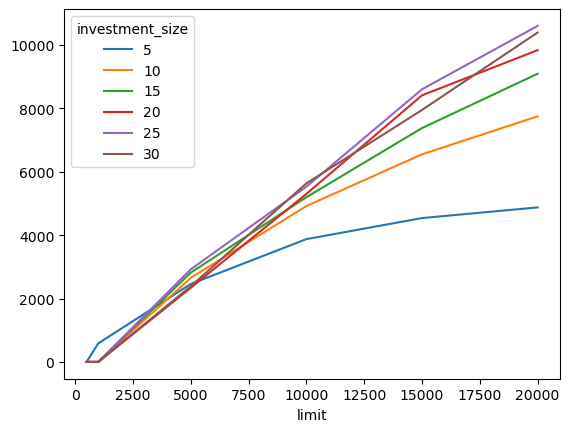

In [15]:
result.groupby(['limit', 'investment_size']).total_profit.mean().unstack().plot()

<AxesSubplot:xlabel='limit'>

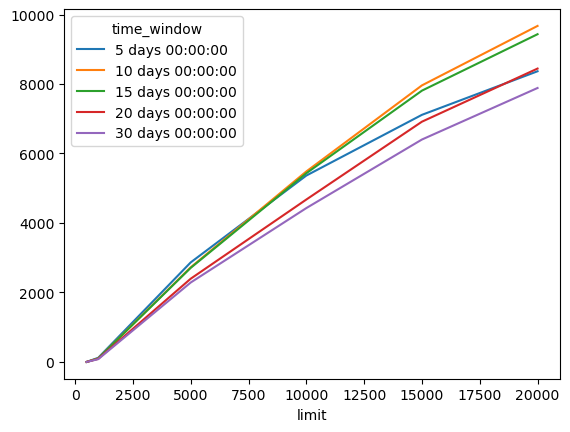

In [16]:
result.groupby(['limit', 'time_window']).total_profit.mean().unstack().plot()

In [17]:
# remove the last row of the dataframe
df = df[:-1]

# add buy, limit and sell points to the dataframe
df['buy_point'] = df.apply(lambda x: x.actual if x.action == 'buy' else np.nan, axis=1)
df['limit_point'] = df.apply(lambda x: x.actual if x.action == 'limit' else np.nan, axis=1)
df['sell_point'] = df.apply(lambda x: x.actual if x.action == 'sell' else np.nan, axis=1)

total_profit = df.total_profit.iloc[-1].ast

AttributeError: 'numpy.float64' object has no attribute 'ast'

In [ ]:
# Create subplots, one for each trace
fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# Add each trace to a separate subplot
fig.add_trace(go.Scatter(x=df.index, y=df.actual     , mode='lines'  , marker=dict(color='blue'  , size=5), name='actual'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df.buy_point  , mode='markers', marker=dict(color='green' , size=5), name='buy'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df.limit_point, mode='markers', marker=dict(color='yellow', size=2), name='sell'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df.sell_point , mode='markers', marker=dict(color='red'   , size=2), name='sell'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.index, y=df.profit, mode='lines', name='profit'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df.shares, mode='lines', name='shares'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df.investment, mode='lines', name='investment'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df.total_profit, mode='lines', name='total_profit'), row=3, col=1)


# Update layout
fig.update_layout(title=f"[{symbol}] Total profit: {total_profit:,} €".replace(',', '.'), template='plotly_dark', height=800)

# Add titles to the subplots
fig.update_yaxes(title_text="Price and Points", row=1, col=1)
fig.update_yaxes(title_text="Total Profit", row=2, col=1)

# Show the figure
fig.show()
pd.concat([df.select_dtypes(include='number').fillna(0).astype(int), df[['action']]], axis=1)

In [ ]:
df.head(50)